### List of dependencies
- networkx
- pandas
- numpy
- matplotlib
- community : you can download it [here](https://bitbucket.org/taynaud/python-louvain/get/6a3696fdce57.zip), then just do  : `sudo python3 setup.py install`
 

In [1]:
import pandas as pd
import numpy as np
import community

#import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
import community
%matplotlib inline

In [2]:
df = pd.read_csv("../data/dataset.CSV", sep=";")

In [3]:
offset_male_id = max(df["female_id"]) + 10000
df["male_id"] = df["male_id"] + offset_male_id

### Let's create the graph, we are going to use Multi Graph because we may have multiple edges between the same escort and client

In [4]:
df_trunc = df[(df.date > 1000) & (df.date < 2000)]

In [5]:
list_male_id = df_trunc["male_id"].unique()
list_female_id = df_trunc["female_id"].unique()

In [6]:
full_node_list = list(list_female_id) + list(list_male_id)

In [7]:
def print_stat_inf(G, display=False, freq = False):
    number_of_nodes = G.number_of_nodes()
    number_infected = 0
    
    for node, data in G.nodes_iter(data=True):
        if data["status"] == "infected":
            number_infected += 1
    if display==True:
        print("Number of infected : ",number_infected)
        print(number_infected/number_of_nodes * 100,"% of the population infected.")
        
    if freq == False:
        res = number_infected
        
    elif freq == True:
        res = number_infected / number_of_nodes
    return res

## SI model

In [8]:
proba_transmission = .8
coeff_initial_infected = .20


### Standard infection

Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  10016
82.42264647794602 % of the population infected.
CPU times: user 1min 30s, sys: 108 ms, total: 1min 30s
Wall time: 1min 30s


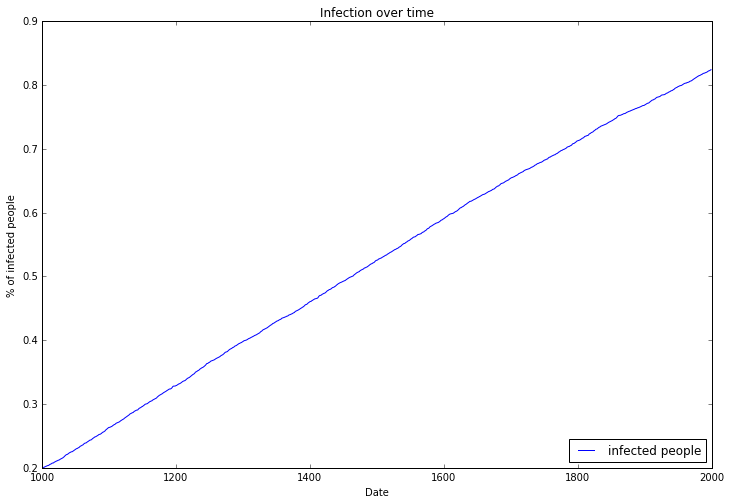

In [9]:
%%time


G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")

n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)

initially_infected = random.sample(population=full_node_list, k=n_initially_infected)


value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_initial = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


### Random initial vaccination at 5%

In [10]:
coeff_initial_vacc = .05


Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  9345
76.90092165898618 % of the population infected.
CPU times: user 1min 59s, sys: 128 ms, total: 1min 59s
Wall time: 1min 59s


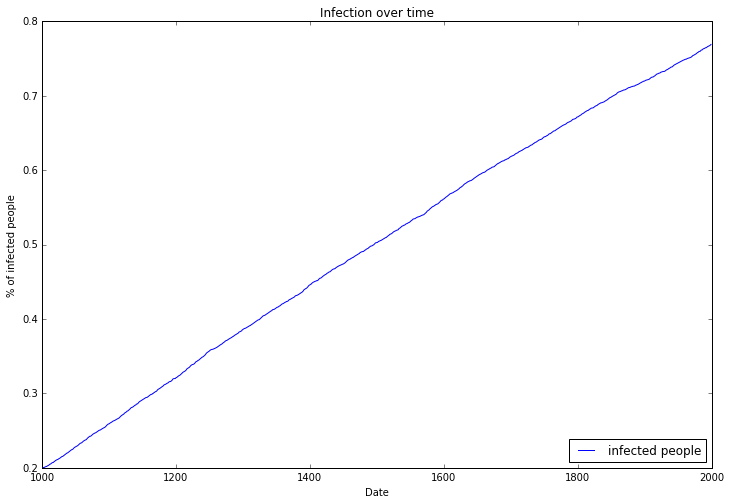

In [11]:
%%time

#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)


# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
list_susceptible = []
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        list_susceptible.append(node)
    
initially_vacc = random.sample(population=list_susceptible, k=n_initially_vacc)

value_dict = {}
for node in initially_vacc:
    value_dict[node] = "vaccined"

nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_005 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  8761
72.09512837393022 % of the population infected.
CPU times: user 1min 47s, sys: 140 ms, total: 1min 47s
Wall time: 1min 47s


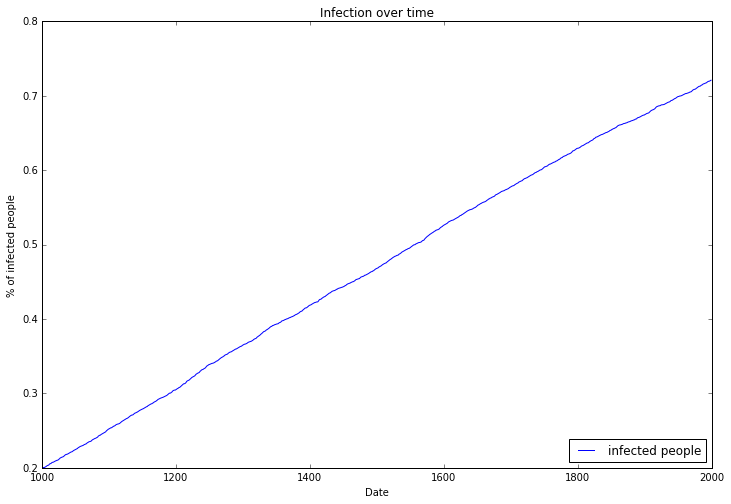

In [12]:
%%time
coeff_initial_vacc = .1


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)


# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
list_susceptible = []
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        list_susceptible.append(node)
    
initially_vacc = random.sample(population=list_susceptible, k=n_initially_vacc)

value_dict = {}
for node in initially_vacc:
    value_dict[node] = "vaccined"

nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_010 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  7447
61.28209348255431 % of the population infected.
CPU times: user 1min 58s, sys: 120 ms, total: 1min 58s
Wall time: 1min 58s


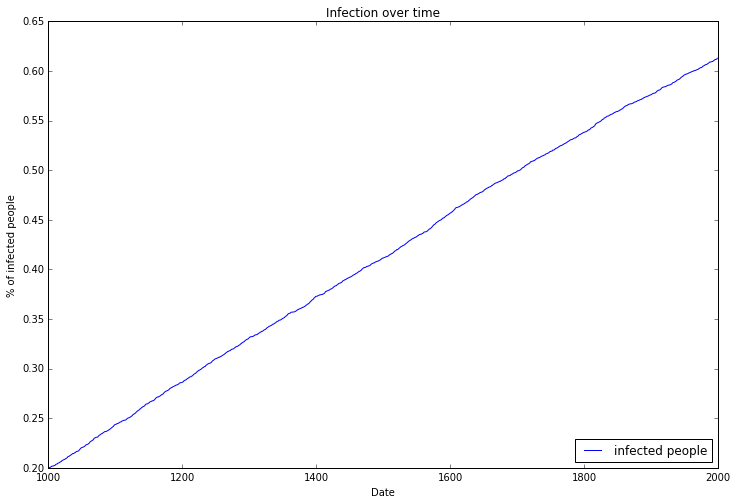

In [13]:
%%time
coeff_initial_vacc = .2


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)


# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
list_susceptible = []
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        list_susceptible.append(node)
    
initially_vacc = random.sample(population=list_susceptible, k=n_initially_vacc)
value_dict = {}
for node in initially_vacc:
    value_dict[node] = "vaccined"

nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_020 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  4415
36.33146807109941 % of the population infected.
CPU times: user 1min 46s, sys: 40 ms, total: 1min 46s
Wall time: 1min 46s


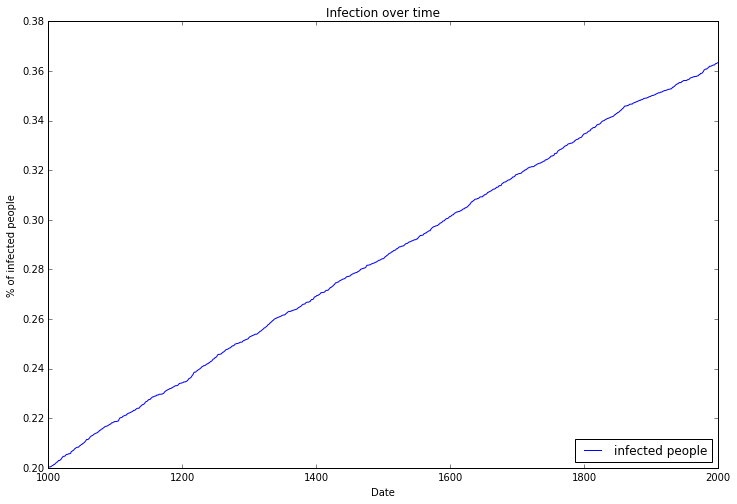

In [14]:
%%time
coeff_initial_vacc = .5


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)


# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
list_susceptible = []
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        list_susceptible.append(node)
    
initially_vacc = random.sample(population=list_susceptible, k=n_initially_vacc)
value_dict = {}
for node in initially_vacc:
    value_dict[node] = "vaccined"

nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_050 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


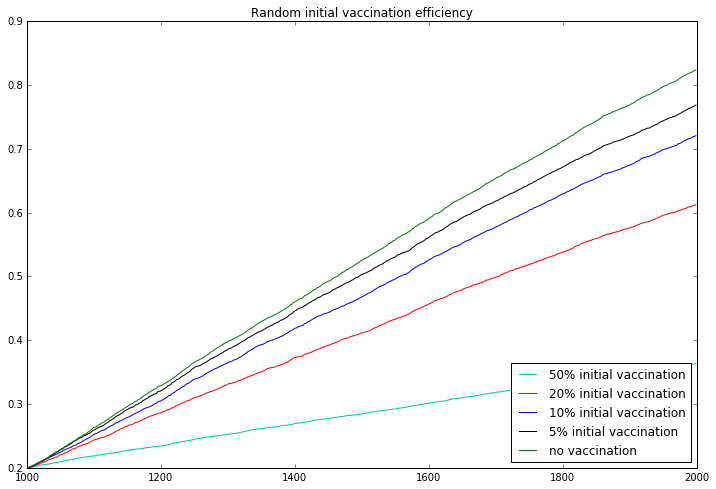

In [15]:
plt.figure(figsize=(12,8))
plt.title("Random initial vaccination efficiency")

plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c",label="50% initial vaccination")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r",label="20% initial vaccination")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b",label="10% initial vaccination")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k",label="5% initial vaccination")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g",label="no vaccination")

plt.legend(loc=4)

### Using community to stop network

In [16]:
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    G.add_edge(row["female_id"], row["male_id"])
        
simple_graph = nx.Graph(G)
partition = community.best_partition(simple_graph)

Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges


In [17]:
print(len(G.nodes()), "nodes in the graph")

12152 nodes in the graph


In [18]:
print(len(G.edges()), " edges in the graph")

34036  edges in the graph


In [19]:
nb_communities = len(set([value for value in partition.values()]))
print(nb_communities, ' communities')

364  communities


In [20]:
partition

{0: 0,
 2: 0,
 32771: 1,
 32772: 2,
 32773: 0,
 32774: 2,
 32775: 2,
 32776: 3,
 32777: 4,
 32778: 5,
 32779: 3,
 15: 0,
 32785: 6,
 18: 3,
 32788: 3,
 21: 3,
 32790: 7,
 32791: 0,
 32792: 3,
 32793: 5,
 32794: 5,
 32795: 3,
 32796: 1,
 32797: 8,
 32798: 9,
 32799: 0,
 32800: 1,
 32801: 7,
 32802: 10,
 32803: 8,
 37: 3,
 32811: 5,
 32812: 0,
 32813: 2,
 32814: 5,
 32815: 0,
 32816: 3,
 32819: 8,
 32821: 11,
 9: 3,
 32824: 3,
 32825: 8,
 32826: 3,
 32827: 3,
 32830: 5,
 32832: 5,
 32833: 0,
 32834: 0,
 32835: 10,
 32836: 0,
 32837: 3,
 32838: 3,
 5473: 7,
 32840: 0,
 32841: 2,
 32842: 3,
 32843: 12,
 76: 0,
 5474: 0,
 32847: 4,
 81: 5,
 32850: 5,
 32851: 0,
 32852: 3,
 32853: 8,
 32854: 3,
 32855: 7,
 32856: 0,
 32857: 1,
 32858: 12,
 32859: 12,
 32860: 0,
 5477: 8,
 98: 0,
 32867: 13,
 32869: 12,
 102: 14,
 32871: 0,
 32872: 8,
 32873: 3,
 32874: 8,
 32875: 5,
 32876: 8,
 32877: 3,
 110: 0,
 114: 6,
 32884: 3,
 32885: 13,
 32886: 0,
 32887: 0,
 32888: 3,
 32889: 3,
 123: 0,
 32893: 10,

### We vaccinate by targetting the bigger communities first
We vaccine everybody in the biggest community, and then under until we reach the % of initally vaccinated on the total population

Number of infected :  2430
19.99670836076366 % of the population infected.
Must vaccine  607  people
0  people vaccinated
Community :  0
To vacc  607
Length community  1716
Sampling  607  people from community  0
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  9368
77.09019091507571 % of the population infected.


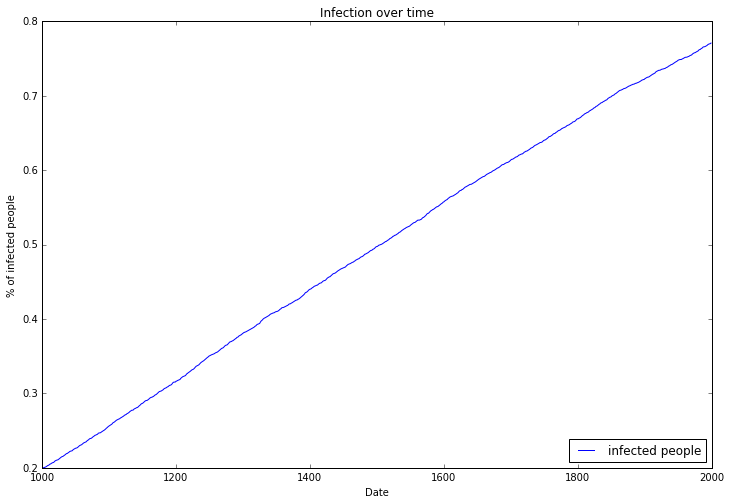

In [21]:
coeff_initial_vacc = .05


### intialize vaccination communities etc


n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

dict_community = {}
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        
        community_object = dict_community.get(partition[node],{})
        community_list = community_object.get("id_list", [])
        community_list.append(node)
        community_object["id_community"] = partition[node]
        community_object["length"] = len(community_list)
        community_object["id_list"] = community_list
        dict_community[partition[node]] = community_object

#print(dict_community)
list_dict = list(dict_community.items())
list_dict = [tuple[1] for tuple in list_dict]
sorted_communities_list = sorted(list_dict, key=lambda d: d["length"], reverse=True)

print('Must vaccine ', n_initially_vacc, " people")
to_vacc = n_initially_vacc
list_to_vacc = []
i = 0
while to_vacc > 0:
    print(len(list_to_vacc)," people vaccinated" )
    print("Community : ", i)
    community = sorted_communities_list[i]
    nb_node_community = community["length"]
    list_id = community["id_list"]
    print("To vacc ", to_vacc)
    print("Length community ", nb_node_community)
    
    if to_vacc >= nb_node_community:
        print("Vaccinating everybody in community")
        list_to_vacc= list_to_vacc + list_id
        to_vacc -= len(list_id)
    else:
        print("Sampling ", to_vacc, " people from community ", i)
        sample = random.sample(population=list_id, k=to_vacc)
        list_to_vacc= list_to_vacc + sample
        
        to_vacc -= len(sample)
    
    i += 1
    
value_dict = {}
for node in list_to_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_com_005 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_com_005.index, groupby_date_vacc_com_005["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Must vaccine  1215  people
0  people vaccinated
Community :  0
To vacc  1215
Length community  1734
Sampling  1215  people from community  0
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  8736
71.88940092165899 % of the population infected.


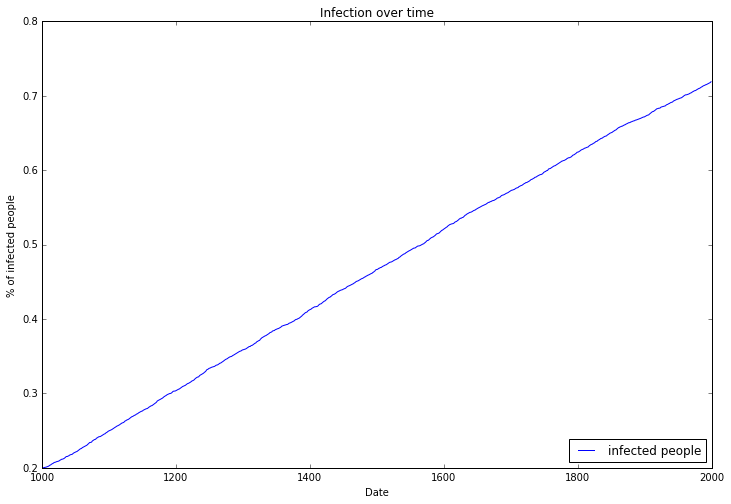

In [22]:
coeff_initial_vacc = .1


### intialize vaccination communities etc


n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

dict_community = {}
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        
        community_object = dict_community.get(partition[node],{})
        community_list = community_object.get("id_list", [])
        community_list.append(node)
        community_object["id_community"] = partition[node]
        community_object["length"] = len(community_list)
        community_object["id_list"] = community_list
        dict_community[partition[node]] = community_object

#print(dict_community)
list_dict = list(dict_community.items())
list_dict = [tuple[1] for tuple in list_dict]
sorted_communities_list = sorted(list_dict, key=lambda d: d["length"], reverse=True)

print('Must vaccine ', n_initially_vacc, " people")
to_vacc = n_initially_vacc
list_to_vacc = []
i = 0
while to_vacc > 0:
    print(len(list_to_vacc)," people vaccinated" )
    print("Community : ", i)
    community = sorted_communities_list[i]
    nb_node_community = community["length"]
    list_id = community["id_list"]
    print("To vacc ", to_vacc)
    print("Length community ", nb_node_community)
    
    if to_vacc >= nb_node_community:
        print("Vaccinating everybody in community")
        list_to_vacc= list_to_vacc + list_id
        to_vacc -= len(list_id)
    else:
        print("Sampling ", to_vacc, " people from community ", i)
        sample = random.sample(population=list_id, k=to_vacc)
        list_to_vacc= list_to_vacc + sample
        
        to_vacc -= len(sample)
    
    i += 1
    
value_dict = {}
for node in list_to_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_com_010 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_com_010.index, groupby_date_vacc_com_010["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Must vaccine  2430  people
0  people vaccinated
Community :  0
To vacc  2430
Length community  1734
Vaccinating everybody in community
1734  people vaccinated
Community :  1
To vacc  696
Length community  1670
Sampling  696  people from community  1
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  7782
64.0388413429888 % of the population infected.


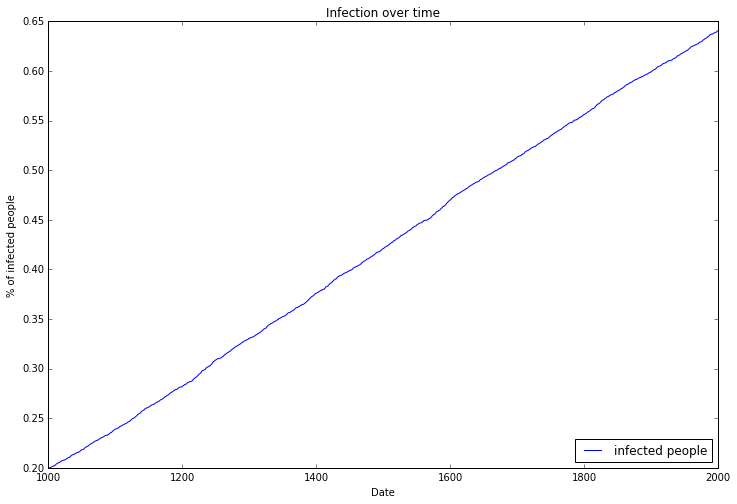

In [23]:
coeff_initial_vacc = .20


### intialize vaccination communities etc


n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

dict_community = {}
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        
        community_object = dict_community.get(partition[node],{})
        community_list = community_object.get("id_list", [])
        community_list.append(node)
        community_object["id_community"] = partition[node]
        community_object["length"] = len(community_list)
        community_object["id_list"] = community_list
        dict_community[partition[node]] = community_object

#print(dict_community)
list_dict = list(dict_community.items())
list_dict = [tuple[1] for tuple in list_dict]
sorted_communities_list = sorted(list_dict, key=lambda d: d["length"], reverse=True)

print('Must vaccine ', n_initially_vacc, " people")
to_vacc = n_initially_vacc
list_to_vacc = []
i = 0
while to_vacc > 0:
    print(len(list_to_vacc)," people vaccinated" )
    print("Community : ", i)
    community = sorted_communities_list[i]
    nb_node_community = community["length"]
    list_id = community["id_list"]
    print("To vacc ", to_vacc)
    print("Length community ", nb_node_community)
    
    if to_vacc >= nb_node_community:
        print("Vaccinating everybody in community")
        list_to_vacc= list_to_vacc + list_id
        to_vacc -= len(list_id)
    else:
        print("Sampling ", to_vacc, " people from community ", i)
        sample = random.sample(population=list_id, k=to_vacc)
        list_to_vacc= list_to_vacc + sample
        
        to_vacc -= len(sample)
    
    i += 1
    
value_dict = {}
for node in list_to_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_com_020 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_com_020.index, groupby_date_vacc_com_020["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Must vaccine  6076  people
0  people vaccinated
Community :  0
To vacc  6076
Length community  1730
Vaccinating everybody in community
1730  people vaccinated
Community :  1
To vacc  4346
Length community  1662
Vaccinating everybody in community
3392  people vaccinated
Community :  2
To vacc  2684
Length community  852
Vaccinating everybody in community
4244  people vaccinated
Community :  3
To vacc  1832
Length community  807
Vaccinating everybody in community
5051  people vaccinated
Community :  4
To vacc  1025
Length community  760
Vaccinating everybody in community
5811  people vaccinated
Community :  5
To vacc  265
Length community  566
Sampling  265  people from community  5
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
A

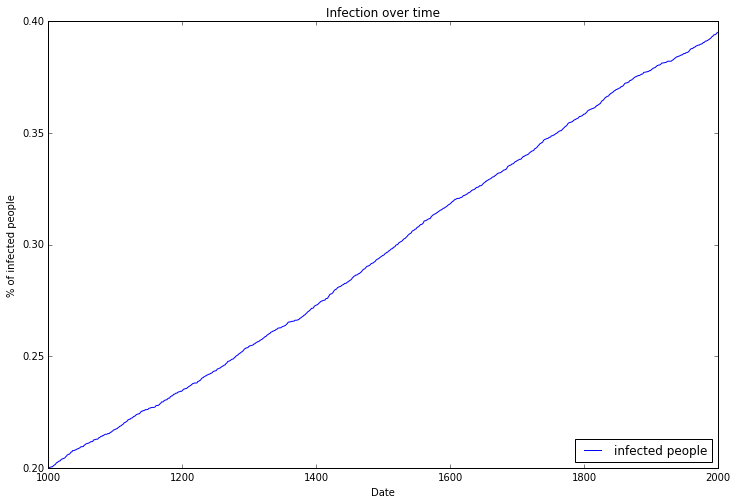

In [24]:
coeff_initial_vacc = .50


### intialize vaccination communities etc


n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)

dict_community = {}
for node,data in G.nodes_iter(data=True):
    if data["status"] == "susceptible":
        
        community_object = dict_community.get(partition[node],{})
        community_list = community_object.get("id_list", [])
        community_list.append(node)
        community_object["id_community"] = partition[node]
        community_object["length"] = len(community_list)
        community_object["id_list"] = community_list
        dict_community[partition[node]] = community_object

#print(dict_community)
list_dict = list(dict_community.items())
list_dict = [tuple[1] for tuple in list_dict]
sorted_communities_list = sorted(list_dict, key=lambda d: d["length"], reverse=True)

print('Must vaccine ', n_initially_vacc, " people")
to_vacc = n_initially_vacc
list_to_vacc = []
i = 0
while to_vacc > 0:
    print(len(list_to_vacc)," people vaccinated" )
    print("Community : ", i)
    community = sorted_communities_list[i]
    nb_node_community = community["length"]
    list_id = community["id_list"]
    print("To vacc ", to_vacc)
    print("Length community ", nb_node_community)
    
    if to_vacc >= nb_node_community:
        print("Vaccinating everybody in community")
        list_to_vacc= list_to_vacc + list_id
        to_vacc -= len(list_id)
    else:
        print("Sampling ", to_vacc, " people from community ", i)
        sample = random.sample(population=list_id, k=to_vacc)
        list_to_vacc= list_to_vacc + sample
        
        to_vacc -= len(sample)
    
    i += 1
    
value_dict = {}
for node in list_to_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)

#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_com_050 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_com_050.index, groupby_date_vacc_com_050["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


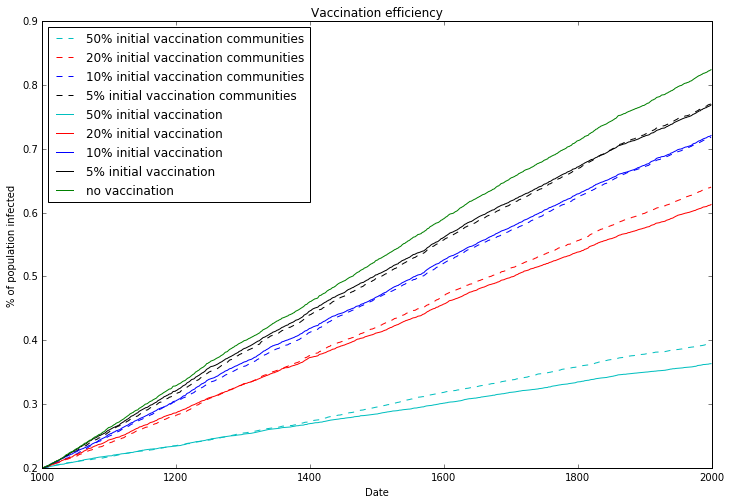

In [25]:
plt.figure(figsize=(12,8))
plt.title("Vaccination efficiency")

plt.plot(groupby_date_vacc_com_050.index, groupby_date_vacc_com_050["nb_infecte"], "c--",label="50% initial vaccination communities")
plt.plot(groupby_date_vacc_com_020.index, groupby_date_vacc_com_020["nb_infecte"], "r--",label="20% initial vaccination communities")
plt.plot(groupby_date_vacc_com_010.index, groupby_date_vacc_com_010["nb_infecte"], "b--",label="10% initial vaccination communities")
plt.plot(groupby_date_vacc_com_005.index, groupby_date_vacc_com_005["nb_infecte"], "k--",label="5% initial vaccination communities")


plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c",label="50% initial vaccination")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r",label="20% initial vaccination")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b",label="10% initial vaccination")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k",label="5% initial vaccination")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g",label="no vaccination")

plt.ylabel("% of population infected")
plt.xlabel("Date")
plt.legend(loc=2)

### use degree to target best nodes in vaccination after random infected (iterate through degree and check infected) 

In [26]:
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    G.add_edge(row["female_id"], row["male_id"])

degree_list = []
for node,data in G.nodes_iter(data=True):
    node_dict = {}
    node_dict["id"] = node
    degree = G.degree(node)
    node_dict["degree"] = degree
    degree_list.append(node_dict)
    
degree_list = sorted(degree_list, key = lambda d : d["degree"], reverse=True)
degree_list = [d["id"] for d in degree_list]

Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges


Number of infected :  2430
19.99670836076366 % of the population infected.
Number to vacc  607
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  6991
57.52962475312706 % of the population infected.


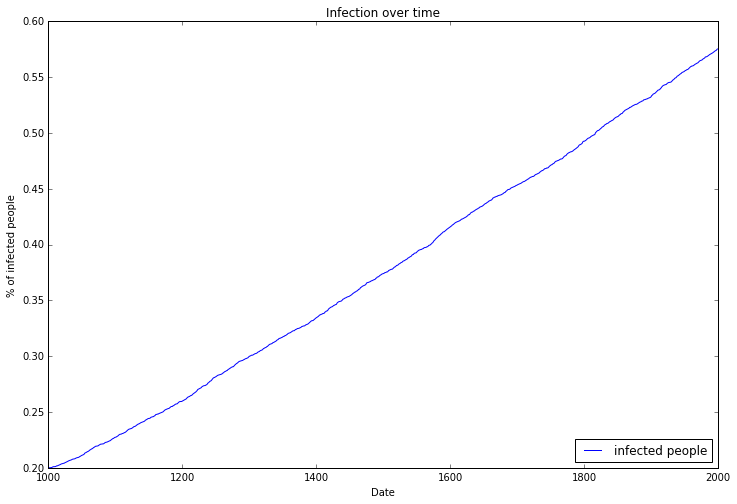

In [27]:
coeff_initial_vacc = .05


### intialize vaccination degree


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
print("Number to vacc ", n_initially_vacc)
list_id_vacc = []
i = 0
while len(list_id_vacc) < n_initially_vacc :
    #print(len(list_id_vacc))
    status = G.node[degree_list[i]]["status"]
    if not(status == "infected"):
        list_id_vacc.append(degree_list[i])
    
    i += 1

value_dict = {}
for node in list_id_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)


#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_deg_005 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_deg_005.index, groupby_date_vacc_deg_005["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Number to vacc  1215
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  5710
46.98815009874917 % of the population infected.


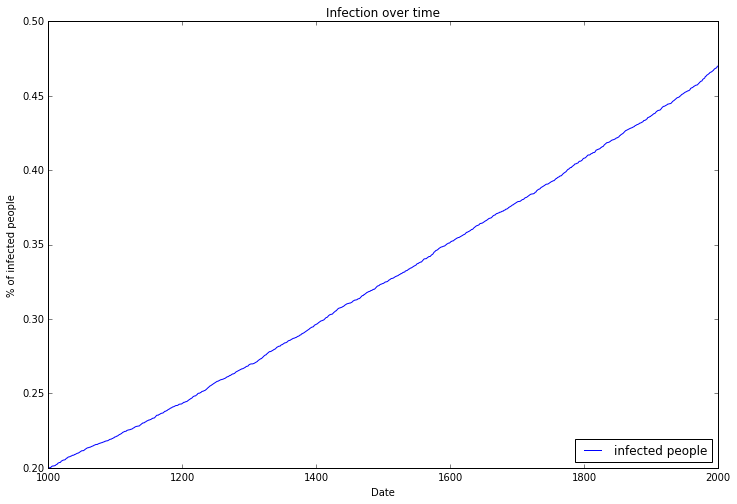

In [28]:
coeff_initial_vacc = .1


### intialize vaccination degree


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
print("Number to vacc ", n_initially_vacc)
list_id_vacc = []
i = 0
while len(list_id_vacc) < n_initially_vacc :
    #print(len(list_id_vacc))
    status = G.node[degree_list[i]]["status"]
    if not(status == "infected"):
        list_id_vacc.append(degree_list[i])
    
    i += 1

value_dict = {}
for node in list_id_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)


#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_deg_010 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_deg_010.index, groupby_date_vacc_deg_010["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Number to vacc  2430
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  4338
35.69782751810401 % of the population infected.


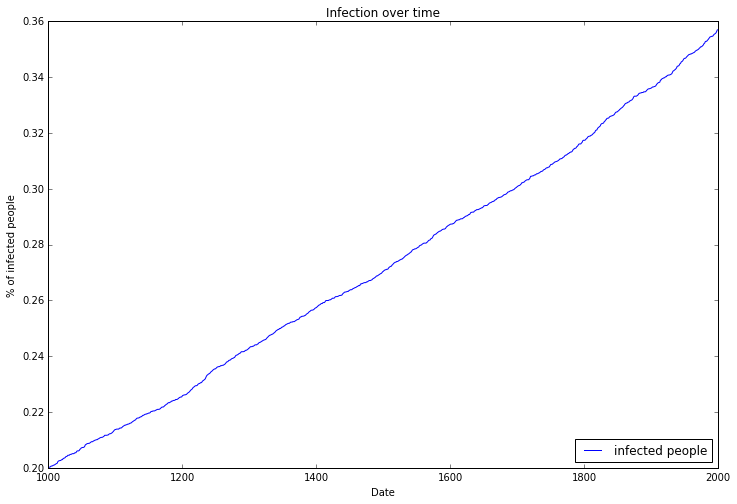

In [29]:
coeff_initial_vacc = .2


### intialize vaccination degree


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
print("Number to vacc ", n_initially_vacc)
list_id_vacc = []
i = 0
while len(list_id_vacc) < n_initially_vacc :
    #print(len(list_id_vacc))
    status = G.node[degree_list[i]]["status"]
    if not(status == "infected"):
        list_id_vacc.append(degree_list[i])
    
    i += 1

value_dict = {}
for node in list_id_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)


#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_deg_020 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_deg_020.index, groupby_date_vacc_deg_020["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


Number of infected :  2430
19.99670836076366 % of the population infected.
Number to vacc  6076
Number of infected :  2430
19.99670836076366 % of the population infected.
Added  9000  edges
Added  12000  edges
Added  15000  edges
Added  18000  edges
Added  21000  edges
Added  24000  edges
Added  27000  edges
Added  30000  edges
Added  33000  edges
Added  36000  edges
Added  39000  edges
Number of infected :  3032
24.950625411454904 % of the population infected.


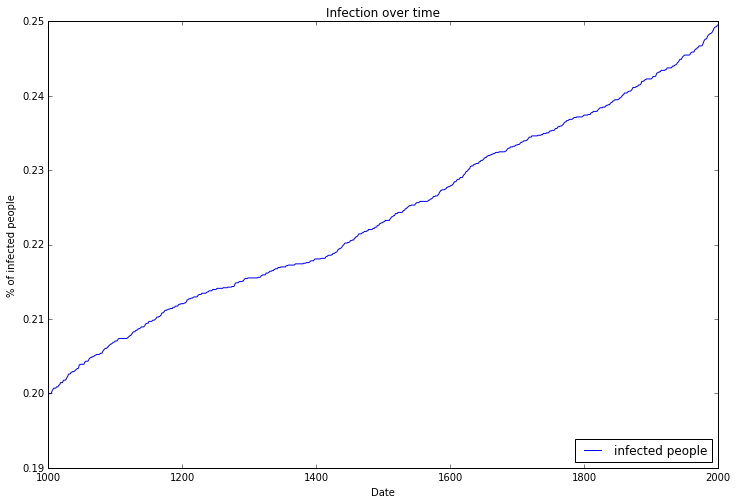

In [30]:
coeff_initial_vacc = .5


### intialize vaccination degree


#Build graph with nodes
G = nx.MultiGraph()
G.add_nodes_from(list_male_id, role="client",status="susceptible")
G.add_nodes_from(list_female_id, role="escort",status="susceptible")


# set initially infected
n_initially_infected = int(G.number_of_nodes() * coeff_initial_infected)
initially_infected = random.sample(population=full_node_list, k=n_initially_infected)
value_dict = {}
for node in initially_infected:
    value_dict[node] = "infected"

nx.set_node_attributes(G, "status", value_dict)

number_infected = print_stat_inf(G, display=True)

# set initially vaccined
n_initially_vacc = int(G.number_of_nodes() * coeff_initial_vacc)
print("Number to vacc ", n_initially_vacc)
list_id_vacc = []
i = 0
while len(list_id_vacc) < n_initially_vacc :
    #print(len(list_id_vacc))
    status = G.node[degree_list[i]]["status"]
    if not(status == "infected"):
        list_id_vacc.append(degree_list[i])
    
    i += 1

value_dict = {}
for node in list_id_vacc:
    value_dict[node] = "vaccined"
nx.set_node_attributes(G, "status", value_dict)


#display initial number of infected
number_infected = print_stat_inf(G, display=True)



##### infection time


date_list = []
infected_list = []

for index, row in df_trunc.iterrows():
    if index % 3000 == 0:
        print("Added ", index, " edges")
    
    #extract data from network
    female_id = row["female_id"]
    male_id = row["male_id"]
    status_male = G.node[male_id]["status"]
    status_female = G.node[female_id]["status"]
    date = row["date"]
    
    #check for transmission with proba_transmission
    if (status_male=="infected") and (status_female=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[female_id]["status"] = "infected"
    
    elif (status_female=="infected") and (status_male=="susceptible"):
        toss = random.uniform(0, 1)
        if toss < proba_transmission:
            G.node[male_id]["status"] = "infected"
    
    number_infected = print_stat_inf(G, freq = True)
    date_list.append(date)
    infected_list.append(number_infected)
    
    
    G.add_edge(row["female_id"], row["male_id"])


df_infection = pd.DataFrame()
df_infection["date"] = date_list
df_infection["nb_infecte"] = infected_list
    
groupby_date_vacc_deg_050 = df_infection.groupby("date").max()    

plt.figure(figsize=(12,8))
plt.title("Infection over time")
plt.plot(groupby_date_vacc_deg_050.index, groupby_date_vacc_deg_050["nb_infecte"], label="infected people")
plt.ylabel("% of infected people")
plt.xlabel("Date")
plt.legend(loc=4)

number_infected = print_stat_inf(G, display=True)


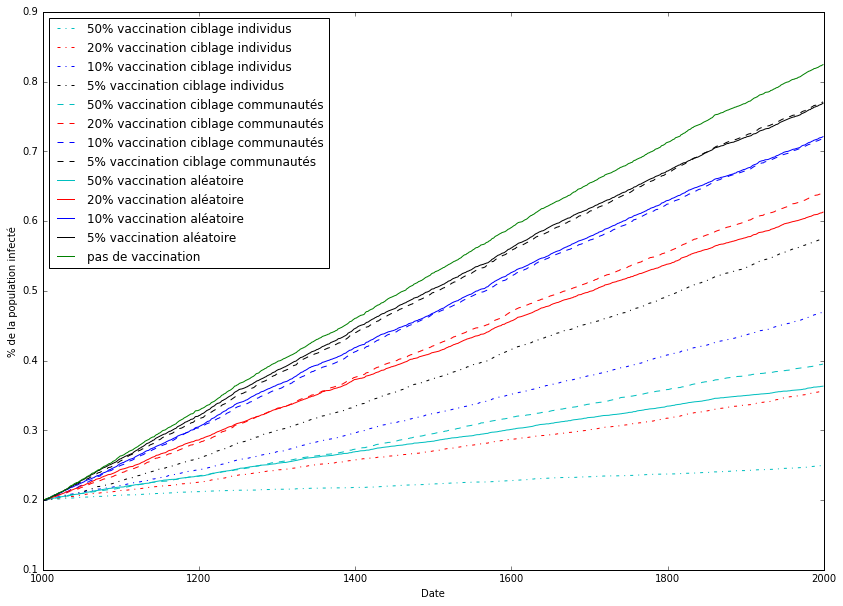

In [31]:
plt.figure(figsize=(14,10))

plt.plot(groupby_date_vacc_deg_050.index, groupby_date_vacc_deg_050["nb_infecte"], "c-.",label="50% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_020.index, groupby_date_vacc_deg_020["nb_infecte"], "r-.",label="20% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_010.index, groupby_date_vacc_deg_010["nb_infecte"], "b-.",label="10% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_005.index, groupby_date_vacc_deg_005["nb_infecte"], "k-.",label="5% vaccination ciblage individus")


plt.plot(groupby_date_vacc_com_050.index, groupby_date_vacc_com_050["nb_infecte"], "c--",label="50% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_020.index, groupby_date_vacc_com_020["nb_infecte"], "r--",label="20% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_010.index, groupby_date_vacc_com_010["nb_infecte"], "b--",label="10% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_005.index, groupby_date_vacc_com_005["nb_infecte"], "k--",label="5% vaccination ciblage communautés")


plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c",label="50% vaccination aléatoire")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r",label="20% vaccination aléatoire")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b",label="10% vaccination aléatoire")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k",label="5% vaccination aléatoire")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g",label="pas de vaccination")

plt.ylabel("% de la population infecté")
plt.xlabel("Date")
plt.legend(loc=2)

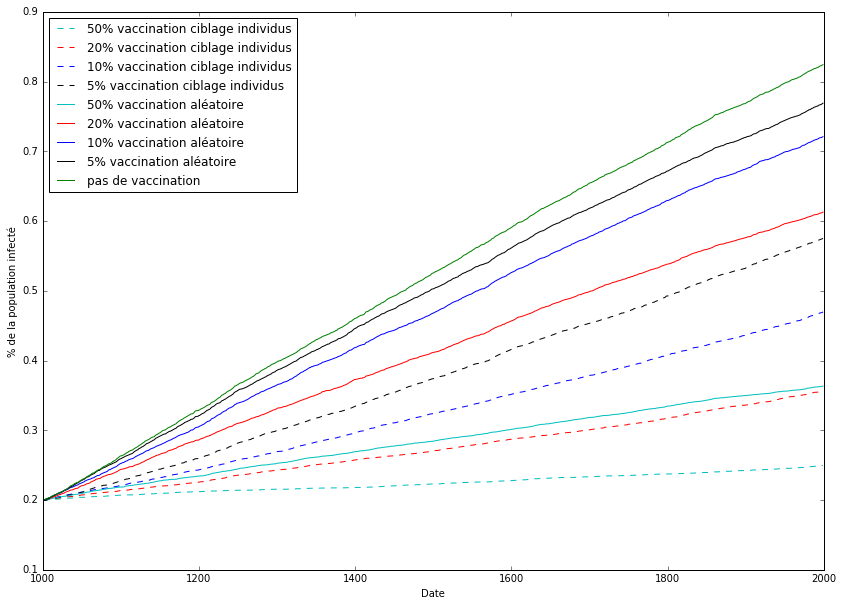

In [32]:
plt.figure(figsize=(14,10))

plt.plot(groupby_date_vacc_deg_050.index, groupby_date_vacc_deg_050["nb_infecte"], "c--",label="50% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_020.index, groupby_date_vacc_deg_020["nb_infecte"], "r--",label="20% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_010.index, groupby_date_vacc_deg_010["nb_infecte"], "b--",label="10% vaccination ciblage individus")
plt.plot(groupby_date_vacc_deg_005.index, groupby_date_vacc_deg_005["nb_infecte"], "k--",label="5% vaccination ciblage individus")

plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c",label="50% vaccination aléatoire")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r",label="20% vaccination aléatoire")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b",label="10% vaccination aléatoire")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k",label="5% vaccination aléatoire")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g",label="pas de vaccination")

plt.ylabel("% de la population infecté")
plt.xlabel("Date")
plt.legend(loc=2)

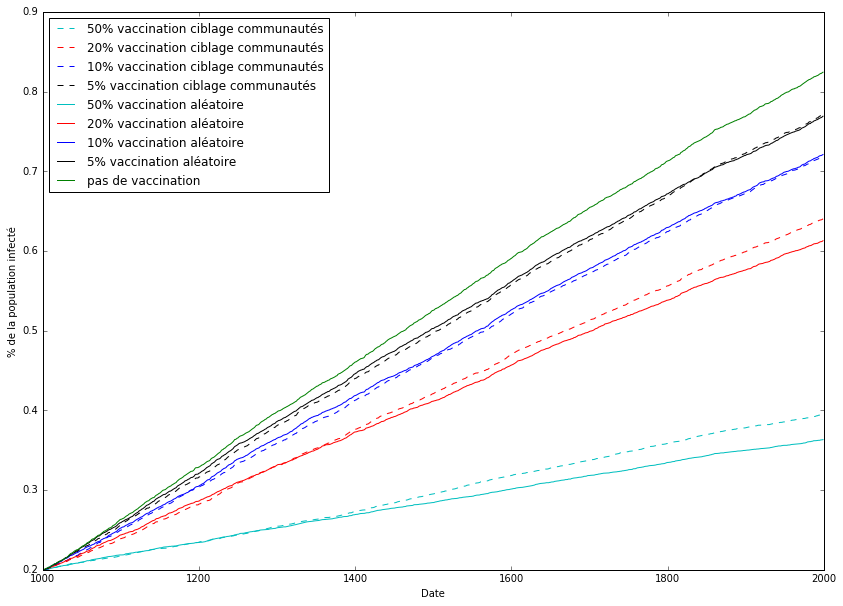

In [33]:
plt.figure(figsize=(14,10))


plt.plot(groupby_date_vacc_com_050.index, groupby_date_vacc_com_050["nb_infecte"], "c--",label="50% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_020.index, groupby_date_vacc_com_020["nb_infecte"], "r--",label="20% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_010.index, groupby_date_vacc_com_010["nb_infecte"], "b--",label="10% vaccination ciblage communautés")
plt.plot(groupby_date_vacc_com_005.index, groupby_date_vacc_com_005["nb_infecte"], "k--",label="5% vaccination ciblage communautés")


plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c",label="50% vaccination aléatoire")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r",label="20% vaccination aléatoire")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b",label="10% vaccination aléatoire")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k",label="5% vaccination aléatoire")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g",label="pas de vaccination")

plt.ylabel("% de la population infecté")
plt.xlabel("Date")
plt.legend(loc=2)

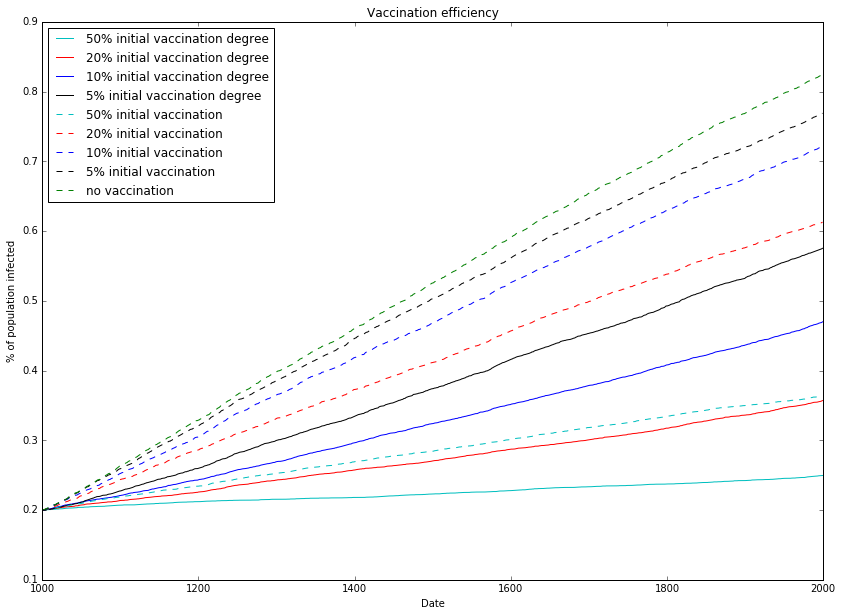

In [34]:
plt.figure(figsize=(14,10))
plt.title("Vaccination efficiency")

plt.plot(groupby_date_vacc_deg_050.index, groupby_date_vacc_deg_050["nb_infecte"], "c",label="50% initial vaccination degree")
plt.plot(groupby_date_vacc_deg_020.index, groupby_date_vacc_deg_020["nb_infecte"], "r",label="20% initial vaccination degree")
plt.plot(groupby_date_vacc_deg_010.index, groupby_date_vacc_deg_010["nb_infecte"], "b",label="10% initial vaccination degree")
plt.plot(groupby_date_vacc_deg_005.index, groupby_date_vacc_deg_005["nb_infecte"], "k",label="5% initial vaccination degree")



plt.plot(groupby_date_vacc_050.index, groupby_date_vacc_050["nb_infecte"], "c--",label="50% initial vaccination")
plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r--",label="20% initial vaccination")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b--",label="10% initial vaccination")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k--",label="5% initial vaccination")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g--",label="no vaccination")

plt.ylabel("% of population infected")
plt.xlabel("Date")
plt.legend(loc=2)

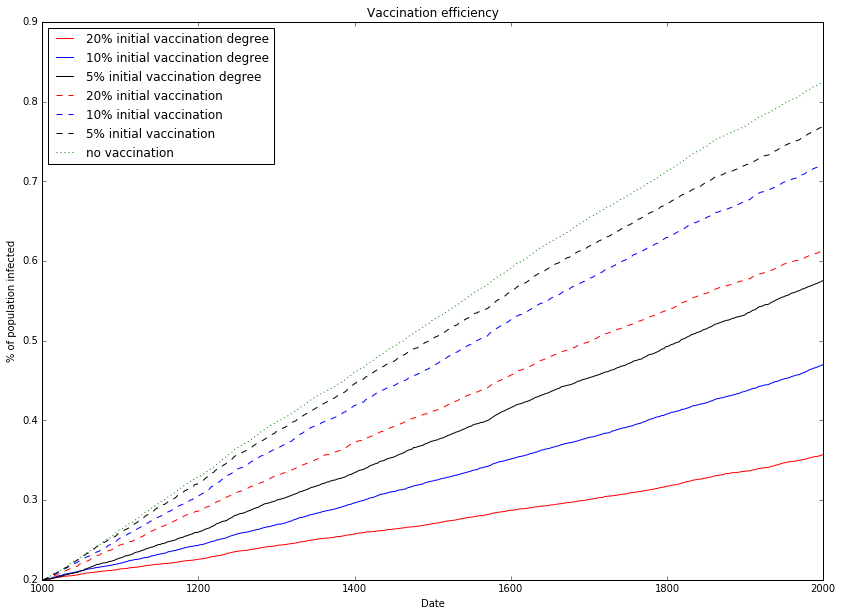

In [35]:
plt.figure(figsize=(14,10))
plt.title("Vaccination efficiency")

plt.plot(groupby_date_vacc_deg_020.index, groupby_date_vacc_deg_020["nb_infecte"], "r",label="20% initial vaccination degree")
plt.plot(groupby_date_vacc_deg_010.index, groupby_date_vacc_deg_010["nb_infecte"], "b",label="10% initial vaccination degree")
plt.plot(groupby_date_vacc_deg_005.index, groupby_date_vacc_deg_005["nb_infecte"], "k",label="5% initial vaccination degree")



plt.plot(groupby_date_vacc_020.index, groupby_date_vacc_020["nb_infecte"], "r--",label="20% initial vaccination")
plt.plot(groupby_date_vacc_010.index, groupby_date_vacc_010["nb_infecte"], "b--",label="10% initial vaccination")
plt.plot(groupby_date_vacc_005.index, groupby_date_vacc_005["nb_infecte"], "k--",label="5% initial vaccination")
plt.plot(groupby_date_initial.index, groupby_date_initial["nb_infecte"], "g:",label="no vaccination")

plt.ylabel("% of population infected")
plt.xlabel("Date")
plt.legend(loc=2)